This file contains the work to generate core users and feeding it to IDCF codebase for amazon beauty ratings dataset.
- greater than 30 interactions are taken into.
- Less than 30 interations are taken into test set
- some x% of coreusers are choosen as training set
- coreusers are calculated using CUR decomposition and R matrix is taken as coreuser.
- always the results are tested on test set.

In [16]:
from fileinput import filename
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.sparse.linalg import svds
import random 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import scipy.stats as ss
import pickle

- code to read and clean douban book review file.

In [19]:
ml1m_dir = 'data/ratings_Beauty.csv'
# ml1m_rating = pd.read_csv(ml1m_dir, sep=',',index_col=0, engine='python')
ml1m_rating = pd.read_csv(ml1m_dir, sep=',', usecols=range(3), names=['uid', 'mid', 'rating'], header=None)
# df = ml1m_rating[["user_id", book_id", "rating", "time"]]
# ml1m_rating.head()
df = ml1m_rating.groupby('uid').filter(lambda x : len(x)>10)
# df = df.groupby('mid').filter(lambda x : len(x)>10)
df = df.groupby('mid').filter(lambda x : len(x)>5)
print("UID LEN:", len(np.unique(df['uid'])))
print("MID LEN:", len(np.unique(df['mid'])))
print("LEN OF DF:", len(df))
# ml1m_rating.to_csv('data/ratings_Beauty_new.csv', index=False)


UID LEN: 10150
MID LEN: 6079
LEN OF DF: 101635


In [20]:
# print(len(df))
df.to_csv('data/ratings_Beauty_new.csv', index=False)

In [15]:
def ReadData(threshold=30):
    # uncomment this line for movielens dataset
    ml1m_dir = 'data/ratings_Beauty_new.csv'
    ml1m_rating = pd.read_csv(ml1m_dir, sep=',', usecols=range(3), header=None, names=['uid', 'mid', 'rating'],  engine='python')
    # use the below 2 lines for pinterest dataset.
    # ml1m_dir = 'data/pin-interest-main.txt'
    # ml1m_rating = pd.read_csv(ml1m_dir, delim_whitespace=True, header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')

    unique_uid = np.unique(np.array(ml1m_rating['uid'].tolist()))
    unique_mid = np.unique(np.array(ml1m_rating['mid'].tolist()))
    uid_dict = dict([(y,x) for x,y in enumerate(unique_uid)])
    mid_dict = dict([(y,x) for x,y in enumerate(unique_mid)])
    print('DICTIONARY PREPARED:')

    # init user item dictionary:
    
    uid_list = ml1m_rating['uid'].tolist()
    uid_list_len = len(uid_list)
    mid_list = ml1m_rating['mid'].tolist()
    mid_list_len = len(mid_list)
    rating_list = ml1m_rating['rating'].tolist()
    user_item_dict = {x:set() for x in range(len(unique_uid))}
    item_user_dict = {x:set() for x in range(len(unique_mid))}
    for i in range(uid_list_len):
        uid_list[i] = uid_dict[uid_list[i]]
        mid_list[i] = mid_dict[mid_list[i]]
        # rating_list[i] = 1 # comment this line if you want to activate explicit ratings
        user_item_dict[uid_list[i]].add(mid_list[i])
        item_user_dict[mid_list[i]].add(uid_list[i])
    tmp_df = pd.DataFrame({"uid":uid_list, "mid":mid_list, "ratings":rating_list})
    v = tmp_df.uid.value_counts()
    df = tmp_df[tmp_df.uid.isin(v.index[v.gt(threshold)])]
### code to store less than 30 interactions:
    df_less_30 = tmp_df[tmp_df.uid.isin(v.index[v.le(threshold)])]
    return df, df_less_30, len(np.unique(mid_list)), len(unique_uid)

In [6]:
THRESHOLD = 5 #split the users into test and train by threshold number of interactions. if greater than threshold then all interactions of that user goes into train set.
df_gt_30, df_le_30, unique_mids, unique_uids = ReadData(THRESHOLD)
print("GREATER THAN 30:\n", df_gt_30)
print("LESS THAN 30: \n", df_le_30)
print("GREATER THAN THRESHOLD: ", len(df_gt_30))
print("LESS THAN THRESHOLD: " ,len(df_le_30))
print("UNIQUE MIDS: ", unique_mids)
print("UNIQUE UIDS: ", unique_uids)

DICTIONARY PREPARED:
GREATER THAN 30:
          uid   mid ratings
1       3880     0     5.0
2       5498     0     3.0
3       7650     0     5.0
4       9781     0     5.0
5       3977     0     5.0
...      ...   ...     ...
101629  7157  6078     5.0
101630  3573  6078     5.0
101631  2267  6078     5.0
101632  5849  6078     5.0
101634  7017  6078     5.0

[90182 rows x 3 columns]
LESS THAN 30: 
           uid   mid ratings
0       10150  6079  rating
8        5757     1     5.0
9       10028     1     5.0
14       9488     1     4.0
22       6259     2     5.0
...       ...   ...     ...
100306   4516  6022     3.0
100839   1199  6045     5.0
101469   2875  6066     4.0
101633   4512  6078     5.0
101635   9609  6078     5.0

[11454 rows x 3 columns]
GREATER THAN THRESHOLD:  90182
LESS THAN THRESHOLD:  11454
UNIQUE MIDS:  6080
UNIQUE UIDS:  10151


In [7]:
support_test_df = df_gt_30.groupby("uid").tail(1)
# print(len(df_gt_30['uid']))
support_train_df = df_gt_30.drop(df_gt_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_gt_30)== len(support_test_df) + len(support_train_df))
# print(len(test_df))
# print(len(train_df))
query_test_df = df_le_30.groupby("uid").tail(1)
query_train_df = df_le_30.drop(df_le_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_le_30)== len(query_test_df) + len(query_train_df))
dic_support_train_df_uid_mapping = dict([(y,x) for x,y in enumerate(np.unique(support_train_df['uid']))])
dic_support_train_df_uid_rmapping = dict([(x,y) for x,y in enumerate(np.unique(support_train_df['uid']))])
### no need for mid mapping

uid_of_train_df = support_train_df['uid'].tolist()
for i in range(len(uid_of_train_df)):
    uid_of_train_df[i] = dic_support_train_df_uid_mapping[uid_of_train_df[i]]
# for index, row in train_df.iterrows():
#     train_df['uid'][index] = dic_train_df_uid_mapping[train_df['uid'][index]]
core_user_ko_input_train_df = pd.DataFrame({'uid':uid_of_train_df, 'mid':support_train_df['mid'], 'ratings':support_train_df['ratings']})
print("NUMBER OF USERS IN SUPPORT TEST:", len(np.unique(support_test_df['uid'])))
print("NUMBER OF USERS IN SUPPORT TRAIN", len(np.unique(support_train_df['uid'])))
print("NUMBER OF USERS IN QUERY TEST:", len(np.unique(query_test_df['uid'])))
print("NUMBER OF USERS IN QUERY TRAIN", len(np.unique(query_train_df['uid'])))

NUMBER OF USERS IN SUPPORT TEST: 6864
NUMBER OF USERS IN SUPPORT TRAIN 6864
NUMBER OF USERS IN QUERY TEST: 3287
NUMBER OF USERS IN QUERY TRAIN 2986


In [8]:
train_ui_dic = {}    
for user in range(unique_uids):
    train_ui_dic[user] = []
for index,row in support_train_df.iterrows():
        train_ui_dic[row['uid']].append(row['mid'])

- utility functions for CUR coreusers.

In [9]:
MAX_MID = 27277 + 1
def select_cols(mat, k, dup=False):
    # prob 1d array of probabilities of all columns
    prob = mat.T.dot(mat)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis = 0)
    prob = prob/denom

    C = np.zeros((mat.shape[0], k))
    ind_cols = np.arange(0, prob.size)
    c_ind = []
    i = 0
    while(i < k):
        rand_sel = np.random.choice(ind_cols, 1, p=prob)
        if rand_sel in c_ind:
            continue
        c_ind.append(rand_sel[0])
        C[:, i] = mat[:, rand_sel[0]]
        i += 1
        # C[:, i] = C[:, i]/np.sqrt(k*prob[rand_sel[0]])

    return C, c_ind

def select_rows(mat, k, dup=False):

    prob = mat.dot(mat.T)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis=0)
    prob = prob/denom
    print(prob)
    r = np.zeros((k, mat.shape[1]))
    ind_rows = np.arange(0, prob.size)
    r_ind = []
    i = 0
    while(i < k):
        # print(ind_rows)
        rand_sel = np.random.choice(ind_rows, 1, p=prob)
        if rand_sel in r_ind:
            continue
        r_ind.append(rand_sel[0])
        r[i, :] = mat[rand_sel[0], :]
        i += 1
        # r[i, :] = r[i, :]/np.sqrt(k*prob[rand_sel[0]])
    r_ind = np.array(r_ind)
    return r, r_ind

# def matIntersection(mat, c_ind, r_ind):
    
#     W = np.zeros((len(r_ind), len(c_ind)))
#     for i in range(len(r_ind)):
#         W[i] = mat[r_ind[i], c_ind]
    
#     return W

# def pseudoInverse(W):
#     # U = WP (W+)

#     # W = X.Z.YT
#     X, Z, YT = np.linalg.svd(W)
    
#     # W+ = Y.Z+.XT
#     XT = X.T
#     Y = YT.T
#     # Z+ = reciprocal(Z)
#     ZP = np.reciprocal(Z)
#     ZP = sp.spdiags(ZP, 0, ZP.size, ZP.size)
#     ZP = ZP@ZP
    
#     # W+ = Y.Z+.XT
#     WP = Y@ZP
#     WP = WP@XT

#     return WP

In [10]:
def ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    df = pd.DataFrame(userItemMatrix)
    cosineSimilarity = cosine_similarity(df)
    print("SHAPE OF COSINE MATIX:\n ", cosineSimilarity.shape)

    listToStoreTopFiftyOfEveryUser = []
    for i in range(0, cosineSimilarity.shape[0]):
        idx = np.argpartition(cosineSimilarity[i], -50)[-50:]
        listToStoreTopFiftyOfEveryUser.append(idx)
    # print("Top fifty list: \n", listToStoreTopFiftyOfEveryUser)
    # listToStoreTopFiftyOfEveryUser = np.array(listToStoreTopFiftyOfEveryUser)
    flatten = np.concatenate(listToStoreTopFiftyOfEveryUser)
    listToStoreTopFiftyOfEveryUser = flatten.ravel()

    # print("List of top 50", listToStoreTopFiftyOfEveryUser)
    df = pd.DataFrame(listToStoreTopFiftyOfEveryUser)
    allUserList = df.value_counts().index.tolist()
    # print("ALL USERS LIST", allUserList)
    allUserList = list(sum(allUserList,()))
    # print("ALL USERS LIST", allUserList)
    twentyPercentUserList = allUserList[:int(len(allUserList)*0.2)]
    # print("TWENTY PERCENT USER:", len(twentyPercentUserList))
    # print("TWENTY PERCENT USER:", (twentyPercentUserList))
    coreusers = dataframe.iloc[np.where(dataframe.uid.isin(twentyPercentUserList))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return coreusers

In [11]:
def CUR_ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    mat = userItemMatrix
    print("MAT:", mat)
    print(mat.shape)
    C, c_ind = select_cols(mat, int(u_len * 0.10)) ## getting 20% core users
    r, r_ind= select_rows(mat, int(u_len * 0.10))
    print("r", r)
    print("r_ind len", len(r_ind))

    cur_coreusers = dataframe.iloc[np.where(dataframe.uid.isin(r_ind))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return cur_coreusers

In [12]:
# core_users = CUR_ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
core_users = ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
support_user_list = np.unique(core_users['uid'])
print("CORE USERS:" ,core_users)
print("NUMBER OF CORE USERS:", len(support_user_list))

USER LEN: 6864
MOVIE LEN: 6080
USER ITEM MATRIX: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
SHAPE OF COSINE MATIX:
  (6864, 6864)
CORE USERS:          uid   mid ratings
20       502     1     2.0
23      3218     2     3.0
28      2103     2     5.0
42      5067     3     5.0
49      5802     5     2.0
...      ...   ...     ...
101583    88  6073     5.0
101588  1588  6074     5.0
101594  6691  6074     5.0
101600  4851  6075     5.0
101602  1505  6075     5.0

[18846 rows x 3 columns]
NUMBER OF CORE USERS: 1372


In [33]:
print(len(support_user_list))
len(np.unique(uid_of_train_df))
# print()

523


5231

In [13]:
core_users_index_list = core_users.index.to_list()
# non_core_user_index = (train_df.index.difference(core_users.index))
# non_core_user_index = non_core_user_index.tolist()

core_users_df = support_train_df.loc[core_users_index_list]
# non_core_user_df = train_df.loc[non_core_user_index]
# print("NON CORE USERS:" ,non_core_user_df)
print("CORE USERS:" ,core_users)

CORE USERS:          uid   mid ratings
20       502     1     2.0
23      3218     2     3.0
28      2103     2     5.0
42      5067     3     5.0
49      5802     5     2.0
...      ...   ...     ...
101583    88  6073     5.0
101588  1588  6074     5.0
101594  6691  6074     5.0
101600  4851  6075     5.0
101602  1505  6075     5.0

[18846 rows x 3 columns]


In [38]:
# print("TEST DF CONTAINS TEST FOR CORE AND NON CORE ENTITIES:\n" ,test_df)
# print(core_users['uid'])
unique_uids_in_support_trian = np.unique(np.array(core_users_df['uid']))
unique_uids_in_query_trian = np.unique(query_train_df['uid'])
print(len(unique_uids_in_support_trian))
support_test_df = support_test_df.loc[support_test_df['uid'].isin(unique_uids_in_support_trian)]
print("SUPPORT TEST DF:" ,support_test_df)
query_test_df = query_test_df
print("QUERY TEST DF:\n", query_test_df)

274
SUPPORT TEST DF:          uid    mid  ratings
284      613   6169        4
377     2024  83209        1
8073    1920  72451        3
9197     306   2331        5
9499    1447   1785        5
...      ...    ...      ...
225378  1965  31437        5
225529  1701   9819        2
226241  1740  72519        5
226689  1348   6066        5
226841   837  43146        1

[274 rows x 3 columns]
QUERY TEST DF:
          uid    mid  ratings
295     1707  87421        5
299     1620  18452        4
302     1889  74757        4
307      447  75026        4
346       70  69124        5
...      ...    ...      ...
225124   782  24626        5
225541   658  74333        5
226250  1958  29817        3
226261  1170  69547        4
226705  1960   5762        4

[841 rows x 3 columns]


In [39]:
support_train = []
for index,row in core_users_df.iterrows():
    support_train.append([row['uid'], row['mid'], row['ratings']])
query_train = []
for index, row in query_train_df.iterrows():
    query_train.append([row['uid'], row['mid'], row['ratings']])
support_test = []
for index, row in support_test_df.iterrows():
    support_test.append([row['uid'], row['mid'], row['ratings']])
query_test = []
for index, row in query_test_df.iterrows():
    query_test.append([row['uid'], row['mid'], row['ratings']])
user_his_dic = {}
for u in train_ui_dic.keys():
    user_his_dic[u] = train_ui_dic[u]
user_supp_list = np.unique(core_users_df['uid']).tolist()

In [40]:
import pickle
with open("douban_cos_10_support_as_core.pkl", "wb") as f:
    pickle.dump(support_train, f)
    pickle.dump(query_train, f)
    pickle.dump(support_test, f)
    pickle.dump(query_test, f)
    pickle.dump(user_supp_list, f)
    pickle.dump(user_his_dic, f)

- 10% amabeauty cos coreusers into IDCF

In [21]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 9966/8167
test set size: support/query 686/3286
Epoch 0 Step 10: Train 16.8650 Reg: 1.0829
Test: 16.8221 MAE: 3.9161 RMSE: 4.1015
Val: 17.6789 MAE: 4.0785 RMSE: 4.2046
Epoch 1 Step 20: Train 15.7029 Reg: 0.5412
Test: 15.5392 MAE: 3.7489 RMSE: 3.9420
Val: 16.2050 MAE: 3.8938 RMSE: 4.0255
Epoch 2 Step 30: Train 14.0576 Reg: 0.2991
Test: 13.6505 MAE: 3.4881 RMSE: 3.6947
Val: 13.9234 MAE: 3.5890 RMSE: 3.7314
Epoch 3 Step 40: Train 11.5037 Reg: 0.2934
Test: 10.9043 MAE: 3.0720 RMSE: 3.3022
Val: 10.5645 MAE: 3.0893 RMSE: 3.2503
Epoch 4 Step 50: Train 8.0901 Reg: 0.3294
Test: 7.6395 MAE: 2.5461 RMSE: 2.7640
Val: 6.7677 MAE: 2.4180 RMSE: 2.6015
Epoch 5 Step 60: Train 4.7912 Reg: 0.3890
Test: 4.8487 MAE: 1.9985 RMSE: 2.2020
Val: 3.8726 MAE: 1.7690 RMSE: 1.9679
Epoch 6 Step 70: Train 2.6678 Reg: 0.4475
Test: 3.1426 MAE: 1.5951 RMSE: 1.7728
Val: 2.3095 MAE: 1.3505 RMSE: 1.5197
Epoc

- 20% amabeauty cos coreusers to IDCF

In [6]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 41292/288519
test set size: support/query 2365/39494
Epoch 0 Step 39: Train 15.2832 Reg: 0.7533
Test: 11.0411 MAE: 3.1266 RMSE: 3.3228
Val: 10.3586 MAE: 3.0008 RMSE: 3.2185
Epoch 1 Step 78: Train 4.5030 Reg: 0.7938
Test: 1.5544 MAE: 1.0879 RMSE: 1.2468
Val: 1.4800 MAE: 1.0328 RMSE: 1.2165
Epoch 2 Step 117: Train 1.1798 Reg: 1.0915
Test: 1.2754 MAE: 0.9053 RMSE: 1.1293
Val: 1.3350 MAE: 0.9011 RMSE: 1.1554
Epoch 3 Step 156: Train 1.0416 Reg: 1.0308
Test: 1.2876 MAE: 0.9152 RMSE: 1.1347
Val: 1.3259 MAE: 0.8972 RMSE: 1.1515
Epoch 4 Step 195: Train 0.9415 Reg: 1.0088
Test: 1.2869 MAE: 0.9022 RMSE: 1.1344
Val: 1.3380 MAE: 0.8796 RMSE: 1.1567
Epoch 5 Step 234: Train 0.8642 Reg: 1.0147
Test: 1.2956 MAE: 0.8945 RMSE: 1.1383
Val: 1.3519 MAE: 0.8649 RMSE: 1.1627
Epoch 6 Step 273: Train 0.8059 Reg: 1.0247
Test: 1.3135 MAE: 0.8917 RMSE: 1.1461
Val: 1.3718 MAE: 0.8564 RMSE: 1.1713
Epo

- 40% amabeauty cos core user as input to IDCF

In [2]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 34653/8167
test set size: support/query 2745/3286
Epoch 0 Step 33: Train 16.5932 Reg: 0.6669
Test: 13.3040 MAE: 3.4562 RMSE: 3.6475
Val: 12.7724 MAE: 3.3989 RMSE: 3.5738
Epoch 1 Step 66: Train 6.5926 Reg: 0.6292
Test: 2.6675 MAE: 1.4733 RMSE: 1.6333
Val: 1.9269 MAE: 1.2319 RMSE: 1.3881
Epoch 2 Step 99: Train 1.2078 Reg: 0.9680
Test: 1.4493 MAE: 1.0097 RMSE: 1.2039
Val: 1.1905 MAE: 0.8861 RMSE: 1.0911
Epoch 3 Step 132: Train 0.9827 Reg: 0.9980
Test: 1.4327 MAE: 1.0043 RMSE: 1.1970
Val: 1.1393 MAE: 0.8665 RMSE: 1.0674
Epoch 4 Step 165: Train 0.8860 Reg: 0.9670
Test: 1.4381 MAE: 1.0014 RMSE: 1.1992
Val: 1.1018 MAE: 0.8475 RMSE: 1.0497
Epoch 5 Step 198: Train 0.8044 Reg: 0.9472
Test: 1.4317 MAE: 0.9837 RMSE: 1.1965
Val: 1.0869 MAE: 0.8234 RMSE: 1.0425
Epoch 6 Step 231: Train 0.7456 Reg: 0.9307
Test: 1.4295 MAE: 0.9694 RMSE: 1.1956
Val: 1.0858 MAE: 0.8047 RMSE: 1.0420
Epoch 7

- 60% amabeauty cos coreusers input to IDCF look into file amabeauty_cos_604654.out for resutls

In [4]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 50207/8167
test set size: support/query 4118/3286
Epoch 0 Step 47: Train 15.0208 Reg: 0.6429
Test: 8.1299 MAE: 2.6511 RMSE: 2.8513
Val: 7.1277 MAE: 2.4721 RMSE: 2.6698
Epoch 1 Step 94: Train 2.4469 Reg: 1.0172
Test: 1.4368 MAE: 1.0037 RMSE: 1.1987
Val: 1.2466 MAE: 0.8991 RMSE: 1.1165
Epoch 2 Step 141: Train 1.0550 Reg: 1.1798
Test: 1.4219 MAE: 1.0011 RMSE: 1.1924
Val: 1.1754 MAE: 0.8784 RMSE: 1.0842
Epoch 3 Step 188: Train 0.9261 Reg: 1.1174
Test: 1.4032 MAE: 0.9763 RMSE: 1.1846
Val: 1.1313 MAE: 0.8432 RMSE: 1.0636
Epoch 4 Step 235: Train 0.8414 Reg: 1.0744
Test: 1.4015 MAE: 0.9543 RMSE: 1.1838
Val: 1.1171 MAE: 0.8172 RMSE: 1.0569
Epoch 5 Step 282: Train 0.7902 Reg: 1.0359
Test: 1.4095 MAE: 0.9408 RMSE: 1.1872
Val: 1.1222 MAE: 0.8033 RMSE: 1.0593
Epoch 6 Step 329: Train 0.7587 Reg: 1.0005
Test: 1.4072 MAE: 0.9265 RMSE: 1.1862
Val: 1.1233 MAE: 0.7902 RMSE: 1.0598
Epoch 7 

- 80% amabeauty cos into IDCF

In [5]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 67321/8167
test set size: support/query 5491/3286
Epoch 0 Step 63: Train 12.5278 Reg: 0.6506
Test: 3.5918 MAE: 1.7276 RMSE: 1.8952
Val: 2.7941 MAE: 1.5034 RMSE: 1.6716
Epoch 1 Step 126: Train 1.3654 Reg: 1.2134
Test: 1.4120 MAE: 0.9918 RMSE: 1.1883
Val: 1.1846 MAE: 0.8767 RMSE: 1.0884
Epoch 2 Step 189: Train 1.0167 Reg: 1.1855
Test: 1.3741 MAE: 0.9665 RMSE: 1.1722
Val: 1.1139 MAE: 0.8352 RMSE: 1.0554
Epoch 3 Step 252: Train 0.9089 Reg: 1.1104
Test: 1.3510 MAE: 0.9347 RMSE: 1.1623
Val: 1.0877 MAE: 0.8035 RMSE: 1.0429
Epoch 4 Step 315: Train 0.8564 Reg: 1.0454
Test: 1.3416 MAE: 0.9126 RMSE: 1.1583
Val: 1.0855 MAE: 0.7859 RMSE: 1.0419
Epoch 5 Step 378: Train 0.8301 Reg: 0.9852
Test: 1.3490 MAE: 0.9032 RMSE: 1.1615
Val: 1.0949 MAE: 0.7801 RMSE: 1.0464
Epoch 6 Step 441: Train 0.8134 Reg: 0.9301
Test: 1.3435 MAE: 0.8882 RMSE: 1.1591
Val: 1.0937 MAE: 0.7728 RMSE: 1.0458
Epoch 7

- 100% amabeauty cos to IDCF

In [6]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 83318/8167
test set size: support/query 6864/3286
Epoch 0 Step 78: Train 10.1638 Reg: 0.8355
Test: 1.6433 MAE: 1.1026 RMSE: 1.2819
Val: 1.3336 MAE: 0.9652 RMSE: 1.1548
Epoch 1 Step 156: Train 1.1798 Reg: 1.3650
Test: 1.3968 MAE: 0.9854 RMSE: 1.1819
Val: 1.1332 MAE: 0.8574 RMSE: 1.0645
Epoch 2 Step 234: Train 0.9869 Reg: 1.2709
Test: 1.3352 MAE: 0.9293 RMSE: 1.1555
Val: 1.0787 MAE: 0.7984 RMSE: 1.0386
Epoch 3 Step 312: Train 0.9152 Reg: 1.1776
Test: 1.3275 MAE: 0.9044 RMSE: 1.1522
Val: 1.0807 MAE: 0.7797 RMSE: 1.0396
Epoch 4 Step 390: Train 0.8862 Reg: 1.0888
Test: 1.3144 MAE: 0.8838 RMSE: 1.1465
Val: 1.0875 MAE: 0.7726 RMSE: 1.0429
Epoch 5 Step 468: Train 0.8722 Reg: 1.0047
Test: 1.3084 MAE: 0.8755 RMSE: 1.1438
Val: 1.0831 MAE: 0.7691 RMSE: 1.0407
Epoch 6 Step 546: Train 0.8640 Reg: 0.9318
Test: 1.3095 MAE: 0.8685 RMSE: 1.1443
Val: 1.0845 MAE: 0.7673 RMSE: 1.0414
Epoch 7

- 10% amabeauty cur input to IDCF

In [7]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 13764/8167
test set size: support/query 686/3286
Epoch 0 Step 13: Train 18.4102 Reg: 0.9992
Test: 17.3008 MAE: 3.9938 RMSE: 4.1594
Val: 17.6620 MAE: 4.0717 RMSE: 4.2026
Epoch 1 Step 26: Train 16.5213 Reg: 0.4199
Test: 15.1467 MAE: 3.7142 RMSE: 3.8919
Val: 15.3343 MAE: 3.7749 RMSE: 3.9159
Epoch 2 Step 39: Train 13.4461 Reg: 0.3417
Test: 11.4717 MAE: 3.1825 RMSE: 3.3870
Val: 11.2304 MAE: 3.1891 RMSE: 3.3512
Epoch 3 Step 52: Train 8.5421 Reg: 0.4223
Test: 6.5821 MAE: 2.3675 RMSE: 2.5656
Val: 5.9219 MAE: 2.2717 RMSE: 2.4335
Epoch 4 Step 65: Train 3.8994 Reg: 0.5482
Test: 3.1291 MAE: 1.6048 RMSE: 1.7689
Val: 2.5408 MAE: 1.4419 RMSE: 1.5940
Epoch 5 Step 78: Train 1.7446 Reg: 0.6534
Test: 1.8420 MAE: 1.2202 RMSE: 1.3572
Val: 1.4253 MAE: 1.0403 RMSE: 1.1939
Epoch 6 Step 91: Train 1.1497 Reg: 0.7106
Test: 1.4901 MAE: 1.0594 RMSE: 1.2207
Val: 1.1552 MAE: 0.8982 RMSE: 1.0748
Epoch 

- 20% amabeauty cur as input to IDCF

In [8]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 25362/8167
test set size: support/query 1372/3286
Epoch 0 Step 24: Train 17.5749 Reg: 0.7630
Test: 15.8213 MAE: 3.8133 RMSE: 3.9776
Val: 16.0213 MAE: 3.8758 RMSE: 4.0027
Epoch 1 Step 48: Train 12.2282 Reg: 0.4302
Test: 8.1057 MAE: 2.6631 RMSE: 2.8471
Val: 7.3436 MAE: 2.5422 RMSE: 2.7099
Epoch 2 Step 72: Train 3.5762 Reg: 0.6954
Test: 1.9233 MAE: 1.2389 RMSE: 1.3868
Val: 1.4607 MAE: 1.0496 RMSE: 1.2086
Epoch 3 Step 96: Train 1.1112 Reg: 0.8877
Test: 1.2986 MAE: 0.9466 RMSE: 1.1396
Val: 1.0271 MAE: 0.8228 RMSE: 1.0135
Epoch 4 Step 120: Train 0.9756 Reg: 0.9089
Test: 1.2531 MAE: 0.9240 RMSE: 1.1194
Val: 0.9912 MAE: 0.8040 RMSE: 0.9956
Epoch 5 Step 144: Train 0.9113 Reg: 0.8866
Test: 1.2436 MAE: 0.9243 RMSE: 1.1152
Val: 0.9625 MAE: 0.7971 RMSE: 0.9811
Epoch 6 Step 168: Train 0.8491 Reg: 0.8675
Test: 1.2326 MAE: 0.9160 RMSE: 1.1102
Val: 0.9402 MAE: 0.7837 RMSE: 0.9696
Epoch 7

- 40%  amabeauty cur coreuser as input to IDCF

In [9]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 45122/8167
test set size: support/query 2745/3286
Epoch 0 Step 42: Train 15.8948 Reg: 0.6233
Test: 10.4008 MAE: 3.0305 RMSE: 3.2250
Val: 9.7124 MAE: 2.9333 RMSE: 3.1165
Epoch 1 Step 84: Train 3.7062 Reg: 0.8595
Test: 1.4779 MAE: 1.0414 RMSE: 1.2157
Val: 1.2865 MAE: 0.9328 RMSE: 1.1343
Epoch 2 Step 126: Train 1.0889 Reg: 1.1149
Test: 1.2956 MAE: 0.9369 RMSE: 1.1382
Val: 1.1676 MAE: 0.8553 RMSE: 1.0806
Epoch 3 Step 168: Train 0.9832 Reg: 1.0538
Test: 1.2769 MAE: 0.9323 RMSE: 1.1300
Val: 1.1072 MAE: 0.8332 RMSE: 1.0522
Epoch 4 Step 210: Train 0.8904 Reg: 1.0001
Test: 1.2433 MAE: 0.9057 RMSE: 1.1150
Val: 1.0776 MAE: 0.8057 RMSE: 1.0381
Epoch 5 Step 252: Train 0.8212 Reg: 0.9611
Test: 1.2158 MAE: 0.8783 RMSE: 1.1026
Val: 1.0601 MAE: 0.7812 RMSE: 1.0296
Epoch 6 Step 294: Train 0.7752 Reg: 0.9277
Test: 1.2124 MAE: 0.8625 RMSE: 1.1011
Val: 1.0565 MAE: 0.7659 RMSE: 1.0279
Epoch 7

- 60% cur amaelec as input to IDCF

In [10]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 60444/8167
test set size: support/query 4118/3286
Epoch 0 Step 57: Train 14.1487 Reg: 0.6752
Test: 5.3960 MAE: 2.1422 RMSE: 2.3229
Val: 4.5041 MAE: 1.9470 RMSE: 2.1223
Epoch 1 Step 114: Train 1.6891 Reg: 1.2027
Test: 1.3325 MAE: 0.9531 RMSE: 1.1543
Val: 1.1453 MAE: 0.8590 RMSE: 1.0702
Epoch 2 Step 171: Train 1.0436 Reg: 1.2392
Test: 1.3207 MAE: 0.9569 RMSE: 1.1492
Val: 1.0783 MAE: 0.8383 RMSE: 1.0384
Epoch 3 Step 228: Train 0.9292 Reg: 1.1415
Test: 1.2933 MAE: 0.9259 RMSE: 1.1372
Val: 1.0449 MAE: 0.8050 RMSE: 1.0222
Epoch 4 Step 285: Train 0.8524 Reg: 1.0708
Test: 1.2781 MAE: 0.9023 RMSE: 1.1305
Val: 1.0395 MAE: 0.7822 RMSE: 1.0195
Epoch 5 Step 342: Train 0.8110 Reg: 1.0101
Test: 1.2727 MAE: 0.8810 RMSE: 1.1281
Val: 1.0379 MAE: 0.7620 RMSE: 1.0188
Epoch 6 Step 399: Train 0.7860 Reg: 0.9589
Test: 1.2743 MAE: 0.8665 RMSE: 1.1288
Val: 1.0422 MAE: 0.7517 RMSE: 1.0209
Epoch 7

- 80% amabeauty cur coreuser input to IDCF

In [11]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 72994/8167
test set size: support/query 5491/3286
Epoch 0 Step 68: Train 11.6940 Reg: 0.7537
Test: 2.3488 MAE: 1.3797 RMSE: 1.5326
Val: 1.8433 MAE: 1.2025 RMSE: 1.3577
Epoch 1 Step 136: Train 1.2129 Reg: 1.3203
Test: 1.3339 MAE: 0.9649 RMSE: 1.1549
Val: 1.1681 MAE: 0.8695 RMSE: 1.0808
Epoch 2 Step 204: Train 0.9915 Reg: 1.2419
Test: 1.2788 MAE: 0.9209 RMSE: 1.1308
Val: 1.1074 MAE: 0.8182 RMSE: 1.0524
Epoch 3 Step 272: Train 0.8927 Reg: 1.1517
Test: 1.2575 MAE: 0.8887 RMSE: 1.1214
Val: 1.0972 MAE: 0.7882 RMSE: 1.0475
Epoch 4 Step 340: Train 0.8478 Reg: 1.0708
Test: 1.2584 MAE: 0.8717 RMSE: 1.1218
Val: 1.0960 MAE: 0.7738 RMSE: 1.0469
Epoch 5 Step 408: Train 0.8240 Reg: 0.9990
Test: 1.2561 MAE: 0.8575 RMSE: 1.1207
Val: 1.1003 MAE: 0.7683 RMSE: 1.0490
Epoch 6 Step 476: Train 0.8111 Reg: 0.9343
Test: 1.2548 MAE: 0.8457 RMSE: 1.1202
Val: 1.1032 MAE: 0.7613 RMSE: 1.0503
Epoch 7

- 100% support user as cos core user to IDCF

In [33]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 94119/4938
test set size: support/query 730/213
Epoch 0 Step 88: Train 5.7745 Reg: 0.4774
Test: 1.1326 MAE: 0.8667 RMSE: 1.0642
Val: 1.1027 MAE: 0.8496 RMSE: 1.0501
Epoch 1 Step 176: Train 0.9613 Reg: 0.4771
Test: 0.9707 MAE: 0.7764 RMSE: 0.9852
Val: 0.9213 MAE: 0.7650 RMSE: 0.9599
Epoch 2 Step 264: Train 0.8752 Reg: 0.4516
Test: 0.9511 MAE: 0.7680 RMSE: 0.9753
Val: 0.8905 MAE: 0.7500 RMSE: 0.9436
Epoch 3 Step 352: Train 0.8573 Reg: 0.4304
Test: 0.9398 MAE: 0.7625 RMSE: 0.9695
Val: 0.8809 MAE: 0.7444 RMSE: 0.9385
Epoch 4 Step 440: Train 0.8505 Reg: 0.4110
Test: 0.9390 MAE: 0.7624 RMSE: 0.9690
Val: 0.8764 MAE: 0.7418 RMSE: 0.9362
Epoch 5 Step 528: Train 0.8464 Reg: 0.3934
Test: 0.9283 MAE: 0.7569 RMSE: 0.9635
Val: 0.8738 MAE: 0.7403 RMSE: 0.9348
Epoch 6 Step 616: Train 0.8440 Reg: 0.3785
Test: 0.9277 MAE: 0.7564 RMSE: 0.9632
Val: 0.8735 MAE: 0.7405 RMSE: 0.9346
Epoch 7 St

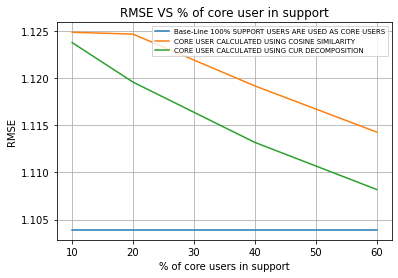

In [1]:
import matplotlib.pyplot as plt

x_axis = [10, 20, 40, 60]
y_axis = [1.1249, 1.1247, 1.11920, 1.1143]
x1_axis = [10, 20, 40, 60]
y1_axis = [1.1039, 1.1039, 1.1039, 1.1039]
x2_axis = [10, 20, 40, 60]
y2_axis = [1.1238, 1.1196, 1.1132, 1.1082]

plt.plot(x1_axis, y1_axis, label="Base-Line 100% SUPPORT USERS ARE USED AS CORE USERS")
plt.plot(x_axis, y_axis, label="CORE USER CALCULATED USING COSINE SIMILARITY")
plt.plot(x2_axis, y2_axis, label="CORE USER CALCULATED USING CUR DECOMPOSITION")

plt.title('RMSE VS % of core user in support')
plt.xlabel('% of core users in support')
plt.ylabel('RMSE')
plt.grid()
plt.legend(fontsize=7)
plt.show()